## Project Description:
This project aims to develop a robust and interpretable classification model to predict the presence of heart disease in patients based on clinical and demographic attributes. Using the UCI Heart Disease dataset.

The primary objective is to identify patients at risk of heart disease, enabling early intervention. The model’s performance and interpretability will both be critical in determining its practical value for deployment in clinical decision support systems.

In [108]:
# Importing the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, roc_curve, auc, RocCurveDisplay

In [ ]:
# Load dataset
df = pd.read_csv('heart_disease_uci.csv')

# Display the shape and first few rows
print("Dataset Shape:", df.shape)
df.head()

### Understanding the data.

In [78]:
# Check dataset info
df.info()


# Check for missing values
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
dtype: int64

Certainly! Here's a **brief description of each column** in the UCI Heart Disease dataset. These features are derived from clinical, demographic, and test-related information gathered from patients:

---

## 📄 **Dataset Columns Description**

| Column Name     | Description |
|------------------|-------------|
| **age**          | Age of the patient in years |
| **sex**          | Sex of the patient: `1 = male`, `0 = female` |
| **cp**           | Chest pain type: <br> `0 = typical angina` <br> `1 = atypical angina` <br> `2 = non-anginal pain` <br> `3 = asymptomatic` |
| **trestbps**     | Resting blood pressure (in mm Hg) on admission |
| **chol**         | Serum cholesterol level (in mg/dl) |
| **fbs**          | Fasting blood sugar: `1 = >120 mg/dl`, `0 = ≤120 mg/dl` |
| **restecg**      | Resting electrocardiographic results: <br> `0 = normal` <br> `1 = ST-T wave abnormality` <br> `2 = probable/definite left ventricular hypertrophy` |
| **thalch**       | Maximum heart rate achieved during a stress test |
| **exang**        | Exercise-induced angina: `1 = yes`, `0 = no` |
| **oldpeak**      | ST depression induced by exercise relative to rest (a measure of heart stress) |
| **target**       | **Target variable** (derived from original `num` column): <br> `0 = No heart disease` <br> `1 = Heart disease present` |


In [79]:
# Getting summary statistics.
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [80]:
# Drop the 'id' column and 'dataset' column if it exists
columns_to_drop = ['id']
if 'dataset' in df.columns:
    columns_to_drop.append('dataset')

df.drop(columns=columns_to_drop,axis=1, inplace=True)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Converting Target to Binary
The num column contains values 0–4. We'll convert it to binary:

0 → No disease

1, 2, 3, 4 → Disease present

In [81]:
# Convert target to binary and rename it to 'target'
df['target'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

# Drop original 'num' column
df.drop(columns=['num'], inplace=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [82]:
# Check missing values again
missing_cleaned = df.isnull().sum()
missing_cleaned[missing_cleaned > 0].sort_values(ascending=False)


ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
dtype: int64

Some columns like 'ca', 'thal', and 'slope' have too many missing values. They will therefore be dropped.

In [83]:
# Drop columns with excessive missing values
columns_to_drop_high_null = ['ca', 'thal', 'slope']
df.drop(columns=columns_to_drop_high_null, inplace=True)

Checking how balanced the dataset is with respect to heart disease.

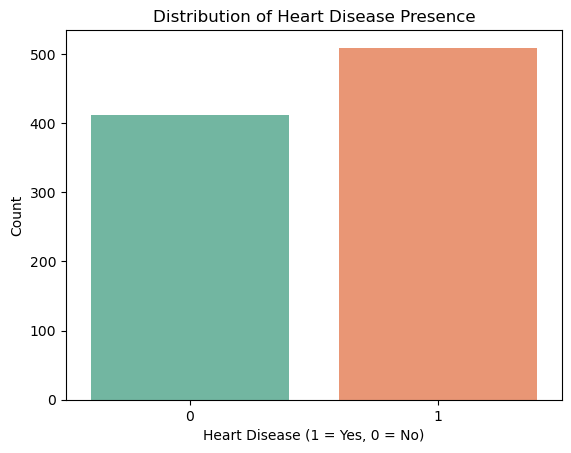

1    0.553261
0    0.446739
Name: target, dtype: float64

In [84]:
# Plot distribution of the target
sns.countplot(x='target', data=df, palette='Set2')
plt.title("Distribution of Heart Disease Presence")
plt.xlabel("Heart Disease (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# Display class proportions
df['target'].value_counts(normalize=True)


The class distribution is very good for the project.

### Numerical columns distribution

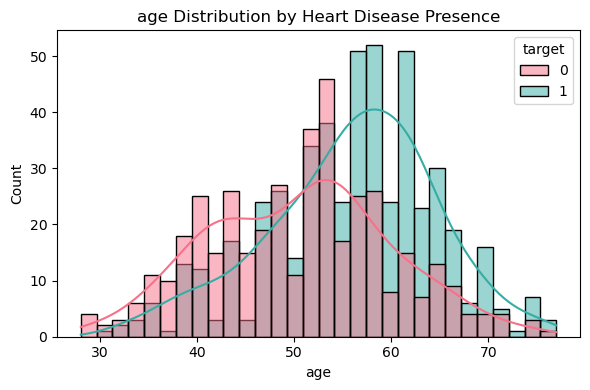

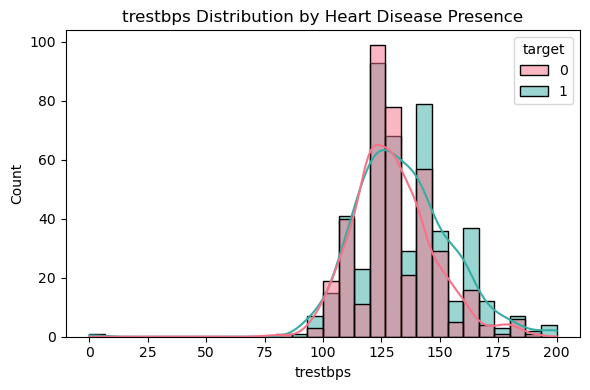

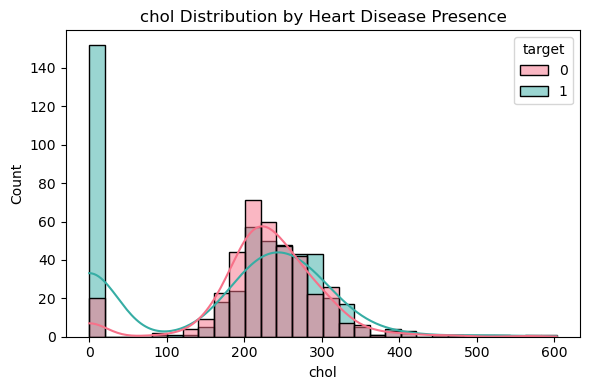

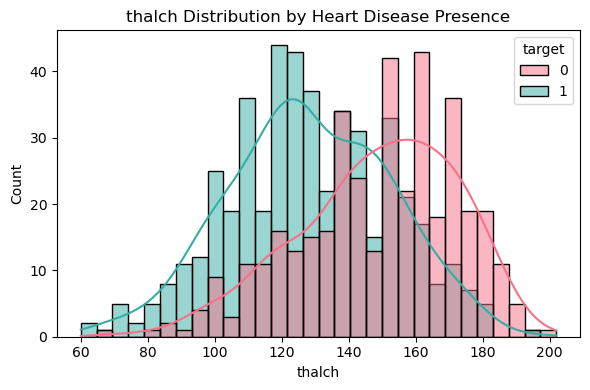

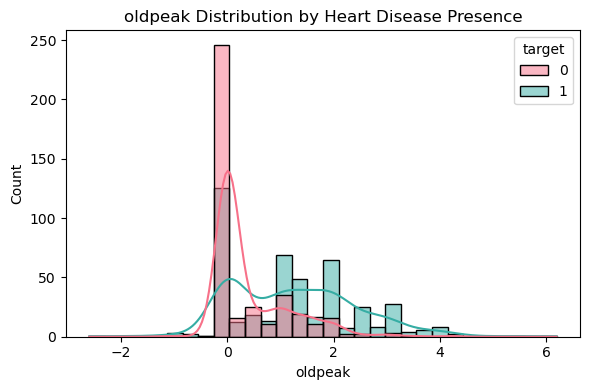

In [85]:
# List of numeric features
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

# Plot distributions of numeric features
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue='target', bins=30, kde=True, palette='husl')
    plt.title(f"{col} Distribution by Heart Disease Presence")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


### Categorical Feature vs Target
Analyzing how categorical variables vary across classes of the target.

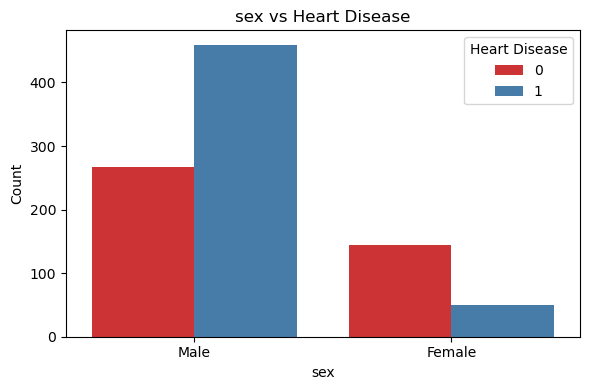

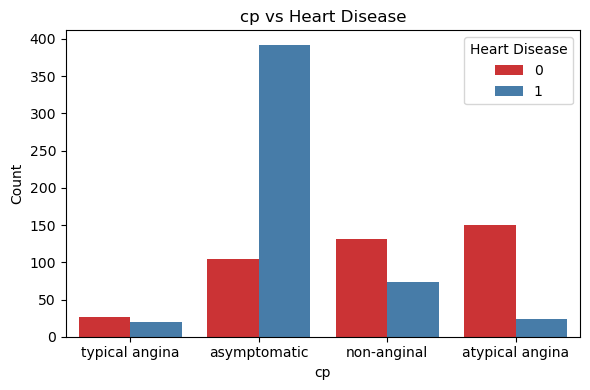

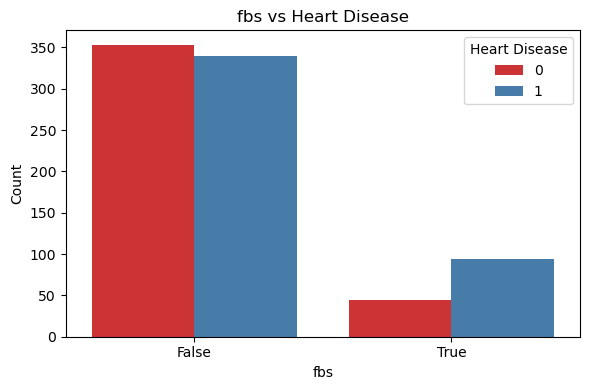

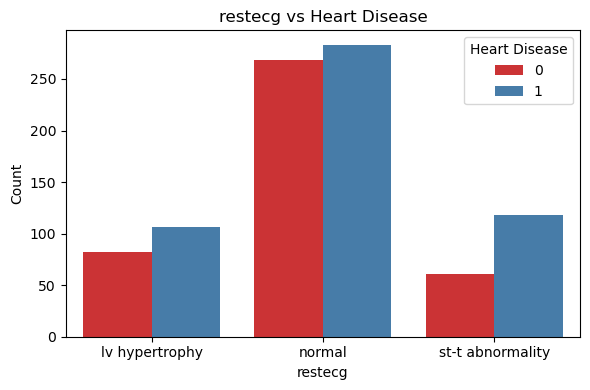

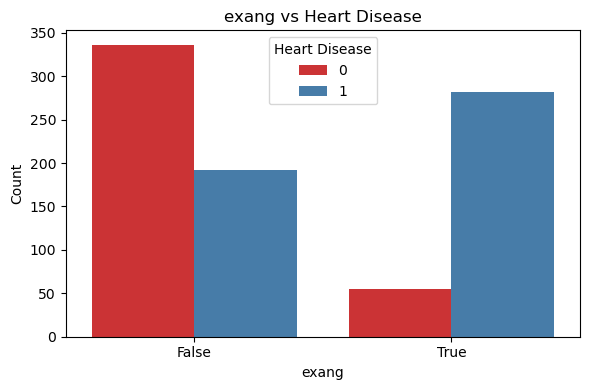

In [86]:
# List of categorical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang']

# Plot bar plots for categorical features
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='target', data=df, palette='Set1')
    plt.title(f"{col} vs Heart Disease")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title='Heart Disease')
    plt.tight_layout()
    plt.show()


In [87]:
# Check average target value per category
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang']

for col in categorical_features:
    print(f"\n--- {col.upper()} ---")
    print(df.groupby(col)['target'].mean().sort_values(ascending=False))



--- SEX ---
sex
Male      0.632231
Female    0.257732
Name: target, dtype: float64

--- CP ---
cp
asymptomatic       0.790323
typical angina     0.434783
non-anginal        0.357843
atypical angina    0.137931
Name: target, dtype: float64

--- FBS ---
fbs
True     0.681159
False    0.489884
Name: target, dtype: float64

--- RESTECG ---
restecg
st-t abnormality    0.659218
lv hypertrophy      0.563830
normal              0.513612
Name: target, dtype: float64

--- EXANG ---
exang
True     0.836795
False    0.363636
Name: target, dtype: float64


 Most predictive categorical features:

cp (especially asymptomatic chest pain)

exang (angina from exercise)

sex (male)

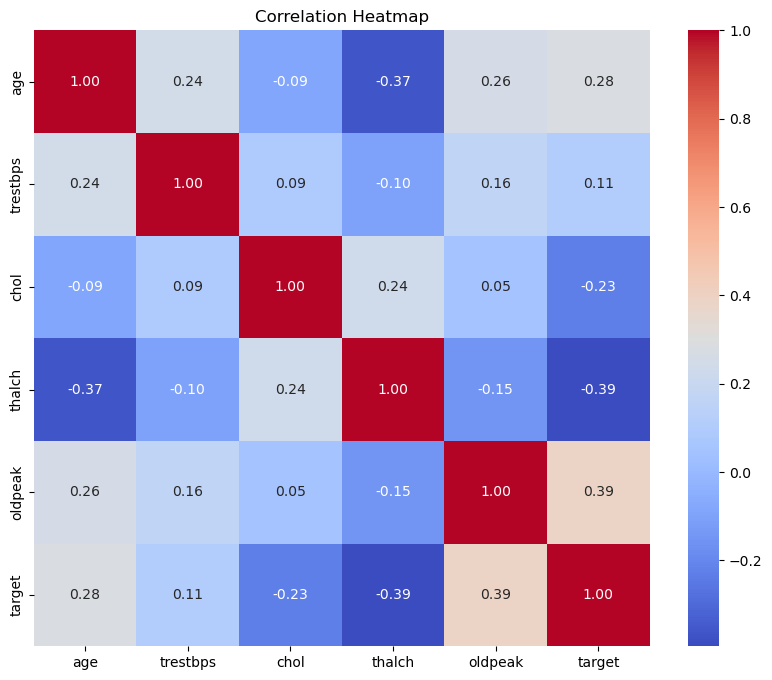

Top features correlated with target:

oldpeak     0.385528
age         0.282700
trestbps    0.106233
chol       -0.230583
thalch     -0.394503
Name: target, dtype: float64


In [88]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Correlation with target only
target_corr = corr['target'].drop('target').sort_values(ascending=False)
print("Top features correlated with target:\n")
print(target_corr)


### Insights.
Oldpeak and thalch are the most predictive features (with opposite directions).

Cholesterol shows an inverse relationship — unusual, but not uncommon in smaller medical datasets.

We’ll need to scale features like trestbps, chol, thalch, and oldpeak before training models.

Some features may benefit from log transformation or binning (like age or cholesterol).

### Feature engineering.

In [89]:
# Features we will process differently
binary_features = ["sex", "fbs", "exang"]         # Already binary (0 or 1)
multi_cat_features = ["cp", "restecg"]            # Need one-hot encoding
numeric_features = ["age", "trestbps", "chol", "thalch", "oldpeak"]  # Need scaling


# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# Train/test split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [94]:
# For numeric columns: fill missing and scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

# For multi-category features: fill missing and one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first"))  # drop="first" avoids dummy variable trap
])

# For binary features: fill missing and one-hot encode
binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first"))])  # drop="first" avoids dummy variable trap

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, multi_cat_features),
    ("bin", binary_transformer, binary_features)  # pass binary features as they are
])

### Logistic Regression

In [95]:
# Combine preprocessing and model into one pipeline
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))  # simple baseline model
])

# Fit model on training data
pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = pipeline.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80        82
           1       0.82      0.89      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



### Multi-model comparison.

In [99]:
# Define classifiers to try
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
}

# Loop through classifiers
for name, model in classifiers.items():
    print(f"\n Model: {name}")
    
    # Create a fresh pipeline for each model
    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy Score:", round(accuracy_score(y_test, y_pred), 4))



 Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        82
           1       0.82      0.89      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184

Accuracy Score: 0.8315

 Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        82
           1       0.83      0.86      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184

Accuracy Score: 0.8261

 Model: SVM
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        82
           1       0.84      0.86      0.85       102

  

### Observations:
All models perform similarly, with accuracy ~83%.

SVM slightly edges out others in precision, recall, and F1-score for predicting class 1.

Logistic Regression and SVM give a great tradeoff between performance and simplicity/explainability.

Random Forest is still strong and may be improved with tuning.

KNN works surprisingly well but may struggle with high-dimensional data.

### Tuning best performing models.

In [102]:
# Parameter grids
param_grid_logreg = {'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']}

param_grid_svm = {'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['rbf']}

param_grid_rf = {'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]}


In [103]:
# Models
logreg = LogisticRegression(max_iter=1000)
svm = SVC(probability=True)
rf = RandomForestClassifier(random_state=42)

# Pipelines
pipe_logreg = Pipeline([("preprocessing", preprocessor),
    ("classifier", logreg)])

pipe_svm = Pipeline([("preprocessing", preprocessor),
    ("classifier", svm)])

pipe_rf = Pipeline([("preprocessing", preprocessor),
    ("classifier", rf)])


In [104]:
# Grid searches
grid_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=5, scoring='accuracy')
grid_logreg.fit(X_train, y_train)

grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'thalch',
                                                                          'oldpeak']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first')...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['sex',
                                                                          'fbs',
                                                                          'exang'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 5, 10],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [106]:
# Evaluate best models
models = {"Logistic Regression": grid_logreg,
    "SVM": grid_svm,
    "Random Forest": grid_rf
}

for name, model in models.items():
    print(f"\nBest Model: {name}")
    print("Best Parameters:", model.best_params_)
    
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))



Best Model: Logistic Regression
Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.79        82
           1       0.82      0.88      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.82       184

Accuracy Score: 0.8260869565217391

Best Model: SVM
Best Parameters: {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        82
           1       0.83      0.89      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

Accuracy Score: 0.8423

In [109]:
# Defining function for confusion matrix.
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Defining function for roc curve
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


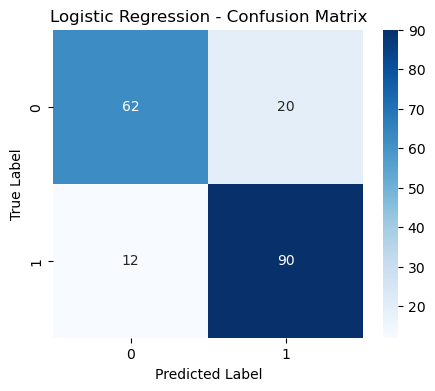

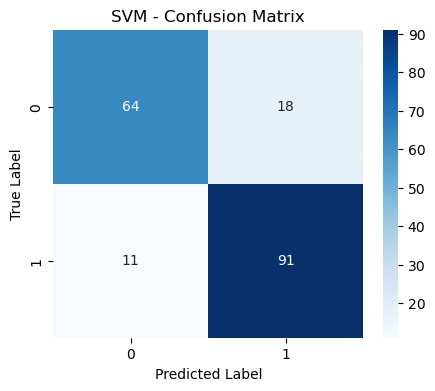

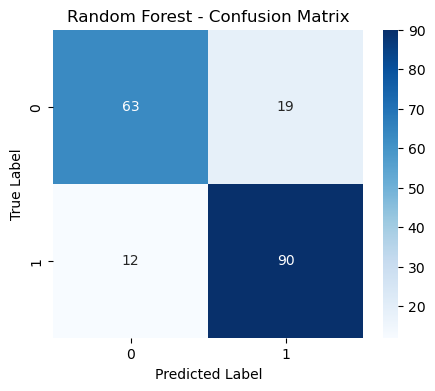

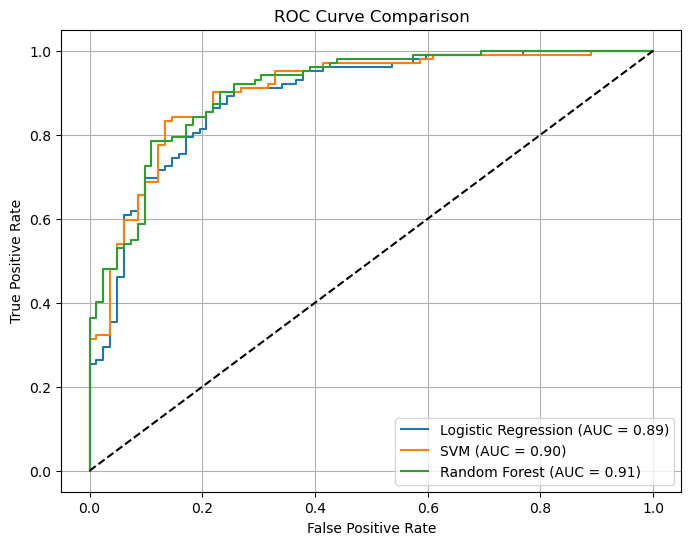

In [110]:
# Get predictions from best models
best_models = {
    "Logistic Regression": grid_logreg.best_estimator_,
    "SVM": grid_svm.best_estimator_,
    "Random Forest": grid_rf.best_estimator_
}

# Plot confusion matrices
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, name)

# Plot ROC curves
plot_roc_curves(best_models, X_test, y_test)


Random forest is the best performing model so will be chosen as the model to deploy for prediction purpose.